In [1]:
from itertools import product, accumulate

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, linregress

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, minmax_scale
from sklearn.linear_model import LinearRegression

from rdkit import Chem
from rdkit.Chem import AllChem, MolFromSmiles, MolToSmiles, MolToInchi, InchiToInchiKey, PandasTools
from rdkit.Chem.Draw import IPythonConsole
import rdkit.Chem.Descriptors as D

from tqdm import tqdm_notebook
%matplotlib inline
pd.set_option('display.max_columns', 500)

## Load the data

In [2]:
df_clean = pd.read_csv('secondary_data/df_clean.csv', index_col=0)
df_molecules_std = pd.read_csv('secondary_data/df_molecules_std.csv', index_col=0)
df_activity = pd.read_csv('secondary_data/df_activity.csv', index_col=0)

In [3]:
std_mols_clean = list(map(MolFromSmiles, df_molecules_std.std_smiles))

In [4]:
df_activity['logIC50'] = np.log10(df_activity.Standard_Value)

In [5]:
df_join = df_activity.join(df_molecules_std, on='std_inchi_key')

In [6]:
df_join.head(8)

,receptor_name,Standard_Value,logIC50,std_smiles,std_inchi,std_morgan_fp,scaffold_smiles,scaffold_inchi,scaffold_morgan_fp,scaffold_inchi_key
std_inchi_key,,,,,,,,,,
AAFYPWXCJRYVKV-ILTCGSTDSA-N,GR,0.89,-0.050610,C[C@]12C[C@H](O)[C@H]3[C@@H](CCC4=Cc5c(cnn5-c5...,InChI=1S/C34H36N4O4S/c1-32-16-20-18-36-38(22-7...,0000000000000000000100000100000001001000000100...,CC(CCC1CC2CCCCC2C1)C1CCC2C1CCC1C3CC4CCC(C5CCCC...,InChI=1S/C39H64/c1-25(11-12-26-21-28-9-5-6-10-...,0110100000000000000000000010010001000000000000...,UFBINBNKQCNFJT-UHFFFAOYSA-N
AAJNWJFLYOFHIB-UHFFFAOYSA-N,GR,17.00,1.230449,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1Cl)C(F...,"InChI=1S/C21H20ClF4NO2/c1-19(2,16-9-15(23)6-7-...",0000000000000000000010000000000001000000000000...,C1CCC(CCCCC2CCCCC2)CC1,InChI=1S/C16H30/c1-3-9-15(10-4-1)13-7-8-14-16-...,0010100000000000000000000000010000000000000000...,UWSSRUCETFDRMI-UHFFFAOYSA-N
AAJNWJFLYOFHIB-UHFFFAOYSA-N,MR,320.00,2.505150,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1Cl)C(F...,"InChI=1S/C21H20ClF4NO2/c1-19(2,16-9-15(23)6-7-...",0000000000000000000010000000000001000000000000...,C1CCC(CCCCC2CCCCC2)CC1,InChI=1S/C16H30/c1-3-9-15(10-4-1)13-7-8-14-16-...,0010100000000000000000000000010000000000000000...,UWSSRUCETFDRMI-UHFFFAOYSA-N
AAJNWJFLYOFHIB-UHFFFAOYSA-N,PR,140.00,2.146128,COc1ccc(F)cc1C(C)(C)CC(O)(Cc1ccc(C#N)cc1Cl)C(F...,"InChI=1S/C21H20ClF4NO2/c1-19(2,16-9-15(23)6-7-...",0000000000000000000010000000000001000000000000...,C1CCC(CCCCC2CCCCC2)CC1,InChI=1S/C16H30/c1-3-9-15(10-4-1)13-7-8-14-16-...,0010100000000000000000000000010000000000000000...,UWSSRUCETFDRMI-UHFFFAOYSA-N
AAPVCQWLJSSUGW-UHFFFAOYSA-N,AR,19000.00,4.278754,Cc1ccccc1OCCSc1nc2ccccc2[nH]1,InChI=1S/C16H16N2OS/c1-12-6-2-5-9-15(12)19-10-...,0000000000000100000000000000000001000000000000...,C1CCC(CCCCC2CC3CCCCC3C2)CC1,InChI=1S/C19H34/c1-2-8-16(9-3-1)10-4-5-11-17-1...,0010100000000000000000000000010000000000000000...,ZMJCPEXMFCFNMF-UHFFFAOYSA-N
AAQPJNXQFGYYCM-UHFFFAOYSA-N,ERa,38620.53,4.586818,Cc1onc(-c2c(F)cccc2Cl)c1C(=O)OCC(=O)NCc1ccco1,InChI=1S/C18H14ClFN2O5/c1-10-15(17(22-27-10)16...,0000000010000001000000000000000001000000010000...,CC(CCC1CCCC1)CCC(C)C1CCCC1C1CCCCC1,InChI=1S/C24H44/c1-19(16-18-21-9-6-7-10-21)15-...,0110100000000000000000000000010001000001000000...,LXJKBSSOZGNXNX-UHFFFAOYSA-N
AAUFIERBXVEOEY-UHFFFAOYSA-N,ERb,3133.78,3.496069,O=C(Nc1ccc2c(c1)OCO2)c1cccc2c1C(=O)N(Cc1cccnc1)C2,InChI=1S/C22H17N3O4/c26-21(24-16-6-7-18-19(9-1...,0000000000010001000100000000000000000000001000...,CC(CC1CCC2CCCC2C1)C1CCCC2CC(CC3CCCCC3)C(C)C21,InChI=1S/C29H50/c1-20(16-23-14-15-24-10-6-11-2...,0110101000000000000000000000010001000001000001...,YKCMVVDGUBHNBL-UHFFFAOYSA-N
AAYYOXKEPZBTIZ-UHFFFAOYSA-N,AR,43.00,1.633468,COc1cc(Sc2c(C)cccc2C)ccc1C#N,InChI=1S/C16H15NOS/c1-11-5-4-6-12(2)16(11)19-1...,0000000000000001000000000000000001000000000000...,C1CCC(CC2CCCCC2)CC1,InChI=1S/C13H24/c1-3-7-12(8-4-1)11-13-9-5-2-6-...,0010100000000000000000000000010000000000000001...,XXKOQQBKBHUATC-UHFFFAOYSA-N


## Exploratory analysis

In [7]:
def plot_kde(x, num_points=1000, *args, **kwargs):
    density = gaussian_kde(x)
    x = np.linspace(np.min(x), np.max(x), num_points)
    plt.plot(x, density(x), *args, **kwargs)

In [8]:
def plot_kde_2d(p_x,p_y, num_points=100, bw_method=None, *args, **kwargs):
    density = gaussian_kde(np.c_[p_x, p_y].T, bw_method)
    x,y = np.linspace(np.min(p_x),np.max(p_x), num_points), np.linspace(np.min(p_y), np.max(p_y), num_points)
    z = density(np.asarray(list(product(x,y))).T).reshape(num_points,num_points).T
#     z = density(list(zip(*product(x,y)))).reshape(num_points,num_points).T
    plt.pcolormesh(x,y,z, *args, **kwargs)

In [9]:
from matplotlib import cm

def make_colormap(x, colormap=cm.plasma):
    return colormap(np.int64(minmax_scale(x)*255))

def plot_scatter_colormap(x,y,z,alpha=0.25,*args,**kwargs):
#     plt.figure()
    plt.scatter(x,y, c=make_colormap(z), alpha=alpha, *args, **kwargs)
    plt.figure()
    plt.axis('off')
    plt.imshow(np.expand_dims(np.asarray(cm.plasma.colors),0),aspect=10)

In [10]:
def plot_linear_regression(x,y,alpha=0.1,*args,**kwargs):
    lr = linregress(x,y)
    plt.scatter(x, y, alpha=alpha,*args,**kwargs)
    min_x = np.min(x)
    max_x = np.max(x)
    line_x = np.asarray([min_x, max_x])
    line_y = lr.intercept + lr.slope*line_x
    plt.plot(line_x, line_y, '--', c='black')
    plt.title('r=%.3f, p=%e, stderr=%.3f' % (lr.rvalue, lr.pvalue, lr.stderr))

Text(0.5, 1.0, 'Number of atoms (log10)')

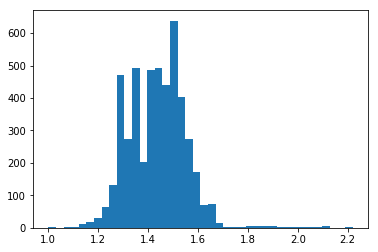

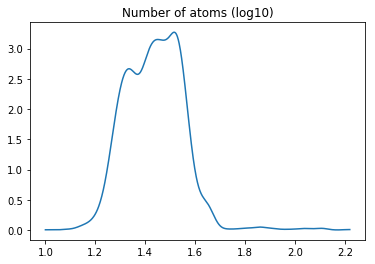

In [11]:
plt.hist(np.log10([x.GetNumAtoms() for x in std_mols_clean]), bins=40)
plt.figure()
plot_kde(np.log10([x.GetNumAtoms() for x in std_mols_clean]))
plt.title('Number of atoms (log10)')

Text(0.5, 1.0, 'logIC50')

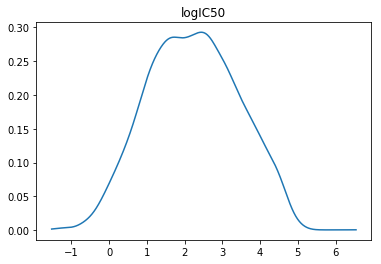

In [12]:
plot_kde(df_activity.logIC50)
plt.title('logIC50')

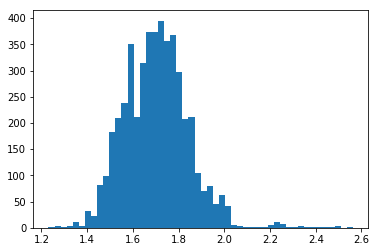

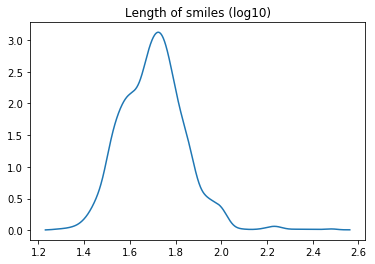

In [13]:
plt.hist(np.log10(list(map(len,df_molecules_std.std_smiles))), bins=50)
plt.figure()
plot_kde(np.log10(list(map(len,df_molecules_std.std_smiles))))
plt.title('Length of smiles (log10)');

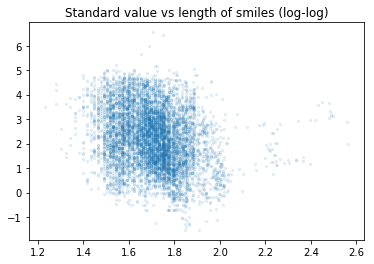

In [14]:
plt.scatter(np.log10(list(map(len,df_join.std_smiles))), df_join.logIC50, alpha=0.1, s=5)
plt.title('Standard value vs length of smiles (log-log)');

Text(0.5, 1.0, 'Standard value vs length of smiles (log-log)')

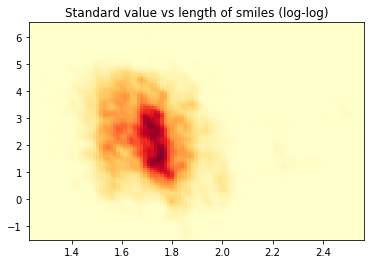

In [15]:
plot_kde_2d(np.log10(list(map(len,df_join.std_smiles))), df_join.logIC50, num_points=100, bw_method=0.1, cmap='YlOrRd')
plt.title('Standard value vs length of smiles (log-log)')

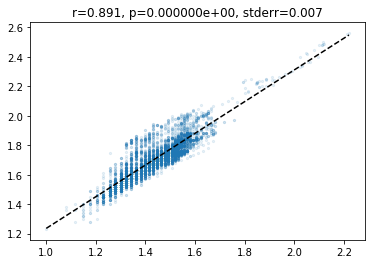

In [16]:
plot_linear_regression(np.log10([MolFromSmiles(x).GetNumAtoms() for x in df_join.std_smiles]), np.log10(list(map(len,df_join.std_smiles))), alpha=0.1, s=5)
# plt.title('Length of smiles vs Number of atoms (log-log)')

## Analysis of ERa ligands

In [11]:
df_era = df_join.query('receptor_name == "ERa"').copy()

In [12]:
df_era['active'] = df_era.Standard_Value < 100

In [13]:
fps          = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_era.std_morgan_fp])
scaffold_fps = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_era.scaffold_morgan_fp])

## Principal component analysis

In [20]:
pca = PCA()
pc = pca.fit_transform(fps)
pca_scaffold = PCA()
pc_scaffold = pca_scaffold.fit_transform(scaffold_fps)

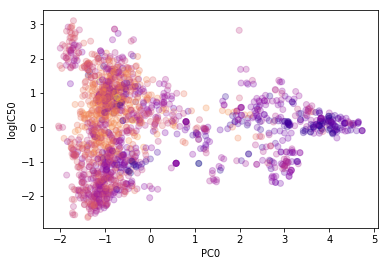

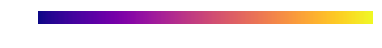

In [21]:
plt.xlabel('PC0')
plt.ylabel('logIC50')
plot_scatter_colormap(pc[:,0], pc[:,1], df_era.logIC50)

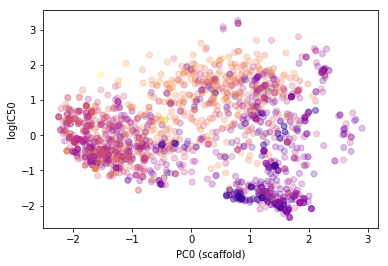

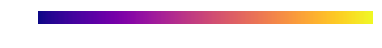

In [22]:
plt.xlabel('PC0 (scaffold)')
plt.ylabel('logIC50')
plot_scatter_colormap(pc_scaffold[:,0], pc_scaffold[:,1],df_era.logIC50)

## Principal component regression analysis

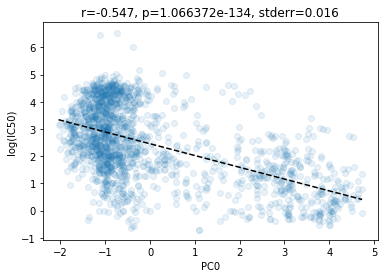

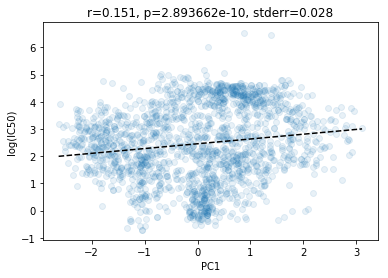

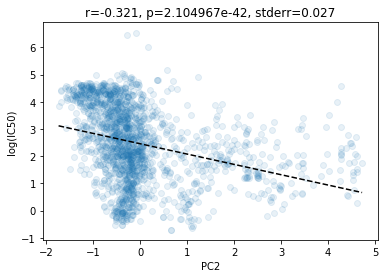

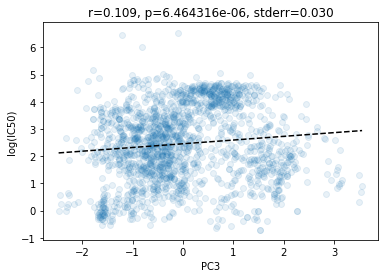

In [23]:
for i in range(4):
    plt.figure()
    plot_linear_regression(pc[:,i], df_era.logIC50)
    plt.xlabel('PC%d' % i)
    plt.ylabel('log(IC50)')

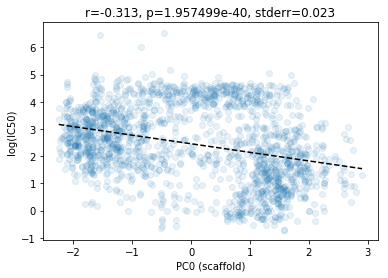

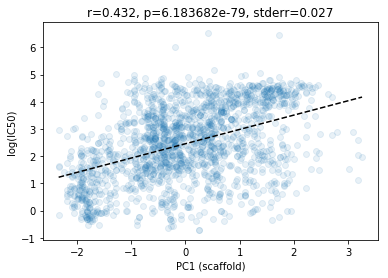

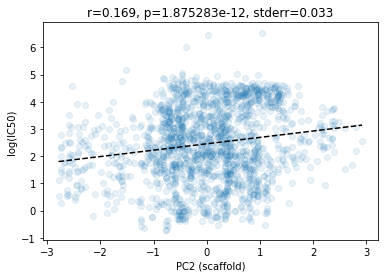

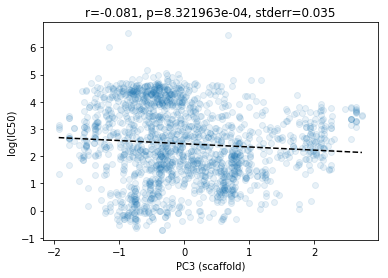

In [24]:
for i in range(4):
    plt.figure()
    plot_linear_regression(pc_scaffold[:,i], df_era.logIC50)
    plt.xlabel('PC%d (scaffold)' % i)
    plt.ylabel('log(IC50)')

## Linear regression on whole fingerprint

In [25]:
lr = LinearRegression()
lr.fit(fps, df_era.logIC50)
r2 = lr.score(fps, df_era.logIC50)
np.sqrt(r2)

0.9642369127772914

In [26]:
lr = LinearRegression()
lr.fit(scaffold_fps, df_era.logIC50)
r2 = lr.score(scaffold_fps, df_era.logIC50)
np.sqrt(r2)

0.9023718688442776

In [27]:
rs = []
for nc in tqdm_notebook(range(1,513)):
    lr = LinearRegression()
    lr.fit(pc[:,:nc], df_era.logIC50)
    r2 = lr.score(pc[:,:nc], df_era.logIC50)
    rs.append(np.sqrt(r2))

KeyboardInterrupt: 

In [ ]:
rs_scaffold = []
for nc in tqdm_notebook(range(1,513)):
    lr = LinearRegression()
    lr.fit(pc_scaffold[:,:nc], df_era.logIC50)
    r2 = lr.score(pc_scaffold[:,:nc], df_era.logIC50)
    rs_scaffold.append(np.sqrt(r2))

NameError: name 'rs_scaffold' is not defined

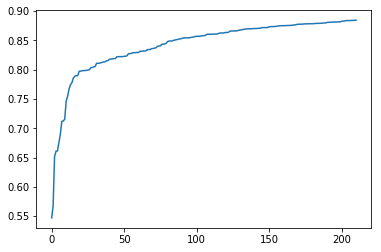

In [28]:
plt.plot(np.asarray(rs)**1, label='mol')
plt.plot(np.asarray(rs_scaffold)**1, label='scaffold')
plt.legend()

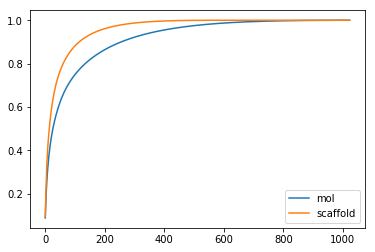

In [29]:
plt.plot(list(accumulate(pca.explained_variance_ratio_)), label='mol')
plt.plot(list(accumulate(pca_scaffold.explained_variance_ratio_)), label='scaffold')
plt.legend()

In [30]:
len(df_era), len(set(df_era.std_smiles)), len(set(df_era.std_morgan_fp)), len(set(df_era.scaffold_smiles)), len(set(df_era.scaffold_morgan_fp))

(1719, 1719, 1622, 1306, 1235)

## Scaffold analysis

In [144]:
df_join \
    .join(df_scaffolds.set_index('scaffold_smiles'), on='scaffold_smiles', lsuffix='_l') \
    .reset_index() \
    .groupby(['cluster_label','receptor_name']) \
    .aggregate(['mean','count', 'std']) \
    .reset_index() \
    .pivot(index='cluster_label', columns='receptor_name') \
    .head(20)

Standard_Value                                       \
                        mean                                        
receptor_name             AR           ERa      ERb            GR   
cluster_label                                                       
1.0                      NaN           NaN      NaN      3.900000   
2.0                      NaN           NaN      NaN      5.000000   
3.0                      NaN           NaN      NaN      4.233333   
4.0                      NaN           NaN      NaN      3.885714   
5.0                      NaN           NaN      NaN      9.000000   
6.0                  12000.0  17000.000000  15000.0           NaN   
7.0                      NaN           NaN      NaN           NaN   
8.0                      NaN           NaN      NaN           NaN   
9.0                      NaN   7300.000000  15000.0  11000.000000   
10.0                     NaN           NaN      NaN           NaN   
11.0                     NaN           NaN      NaN           NaN   
12.0                     NaN           NaN      NaN           NaN   
13.0                     NaN           NaN      NaN           NaN   
14.0                     NaN           NaN      NaN           NaN   
15.0                     NaN           NaN      NaN           NaN   
16.0                     NaN           NaN      NaN           NaN   
17.0                     NaN           NaN      NaN           NaN   
18.0                     NaN           NaN      NaN           NaN   
19.0                     NaN           NaN      NaN           NaN   
20.0                  6000.0   6928.571429   4750.0   5442.857143   

                                                                    \
                                   count                             
receptor_name           MR      PR    AR  ERa  ERb   GR    MR   PR   
cluster_label                                                        
1.0                    NaN     NaN   NaN  NaN  NaN  2.0   NaN  NaN   
2.0                    NaN     NaN   NaN  NaN  NaN  1.0   NaN  NaN   
3.0                    NaN     NaN   NaN  NaN  NaN  3.0   NaN  NaN   
4.0                    NaN     NaN   NaN  NaN  NaN  7.0   NaN  NaN   
5.0                    NaN     NaN   NaN  NaN  NaN  2.0   NaN  NaN   
6.0             101.500000  8100.0   1.0  1.0  1.0  NaN   2.0  1.0   
7.0            2900.000000     NaN   NaN  NaN  NaN  NaN   1.0  NaN   
8.0            1650.000000     NaN   NaN  NaN  NaN  NaN   2.0  NaN   
9.0            1985.172414  3600.0   NaN  1.0  1.0  1.0  29.0  1.0   
10.0           9500.000000     NaN   NaN  NaN  NaN  NaN   2.0  NaN   
11.0           1115.000000     NaN   NaN  NaN  NaN  NaN  10.0  NaN   
12.0            420.000000     NaN   NaN  NaN  NaN  NaN   2.0  NaN   
13.0            600.000000     NaN   NaN  NaN  NaN  NaN   1.0  NaN   
14.0           2000.000000     NaN   NaN  NaN  NaN  NaN   2.0  NaN   
15.0            250.000000     NaN   NaN  NaN  NaN  NaN   1.0  NaN   
16.0            665.000000     NaN   NaN  NaN  NaN  NaN   2.0  NaN   
17.0            500.000000     NaN   NaN  NaN  NaN  NaN   1.0  NaN   
18.0            360.000000     NaN   NaN  NaN  NaN  NaN   5.0  NaN   
19.0            553.333333     NaN   NaN  NaN  NaN  NaN   6.0  NaN   
20.0            542.538462  3650.0   8.0  7.0  8.0  7.0  39.0  8.0   

                                                                   \
                       std                                          
receptor_name           AR          ERa          ERb           GR   
cluster_label                                                       
1.0                    NaN          NaN          NaN     3.535534   
2.0                    NaN          NaN          NaN          NaN   
3.0                    NaN          NaN          NaN     4.772141   
4.0                    NaN          NaN          NaN     4.689946   
5.0                    NaN          NaN          NaN     9.758074   
6.0                    NaN          NaN          NaN   

## ANOVA

In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [15]:
mod = ols('logIC50 ~ scaffold_smiles', data=df_era).fit()

In [16]:
sm.stats.anova_lm(mod, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
scaffold_smiles,534.0,2525.062510,4.728581,7.874979,1.069529e-189
Residual,1183.0,710.339929,0.600456,NaN,NaN


In [17]:
df_t2 = mod.summary2().tables[1]

In [18]:
df_t2_ = df_t2[df_t2['P>|t|'] < 0.05].reset_index().sort_values('P>|t|')

In [19]:
df_t2_['smiles'] = df_t2_['index'].apply(lambda x:x.replace('scaffold_smiles[T.','')[:-1])

In [20]:
scaffold_counts = df_era \
    .join(df_t2_.set_index('smiles'), on='scaffold_smiles') \
    .reset_index() \
    .groupby('scaffold_smiles') \
    .aggregate('count')['std_inchi_key'] \
    .to_frame() \
    .rename(lambda x:x.replace('std_inchi_key', 'count'), axis='columns')

In [21]:
df_t2_.join(scaffold_counts, on='smiles').drop('index',axis='columns').sort_values('count', ascending=False)

,Coef.,Std.Err.,t,P>|t|,[0.025,0.975],smiles,count
32,-1.638328,0.781904,-2.095305,0.036356,-3.172401,-0.104254,C1CCC(CCCC2CCC(C3CC4CCCCC4CC3C3CCCCC3)CC2)CC1,55.0
15,-2.333446,0.783269,-2.979114,0.002950,-3.870197,-0.796696,C1CCC(C2CC3CCCCC3CC2C2CCC(CCCC3CCCC3)CC2)CC1,46.0
75,1.654715,0.785293,2.107131,0.035316,0.113993,3.195437,CC1C2CCCCC2CCC1C1CCCCC1,37.0
45,-2.171938,0.806532,-2.692933,0.007183,-3.754331,-0.589544,CC(C1CCCCC1)C1CCC(C2CCC(C(C)C3C4CCCCC4CC3C3CCC...,12.0
44,-1.675246,0.836978,-2.001541,0.045562,-3.317373,-0.033119,CC(C1CCCCC1)C1CC2CCCCC2C1CC1CCCCC1,6.0
74,1.865798,0.836978,2.229208,0.025987,0.223671,3.507925,CC1C2CCCCC2C2C(C)C3CCCCC3C2C1C1CCCCC1,6.0
71,1.728949,0.848851,2.036812,0.041891,0.063528,3.394370,CC1C2CCCCC2C2C(C)C3CCCCC3C2C1C1CCC(CCCC2CCCCC2...,5.0
19,-2.190446,0.848851,-2.580484,0.009986,-3.855867,-0.525025,C1CCC(C2CCC(C3CC4CCCCC4CC3C3CCCCC3)CC2)CC1,5.0
23,2.053405,0.866355,2.370167,0.017940,0.353642,3.753168,C1CCC(C2CCC3CCCC3C2)C1,4.0
68,-1.742053,0.866355,-2.010785,0.044575,-3.441816,-0.042290,CC(CCCCC1CCCCC1)CC1C2CCCCC2CC1C1CCCCC1,4.0


In [22]:
smiles = df_t2_.join(scaffold_counts, on='smiles').sort_values('count', ascending=False).smiles[:24]

In [23]:
mols = map(MolFromSmiles, smiles)

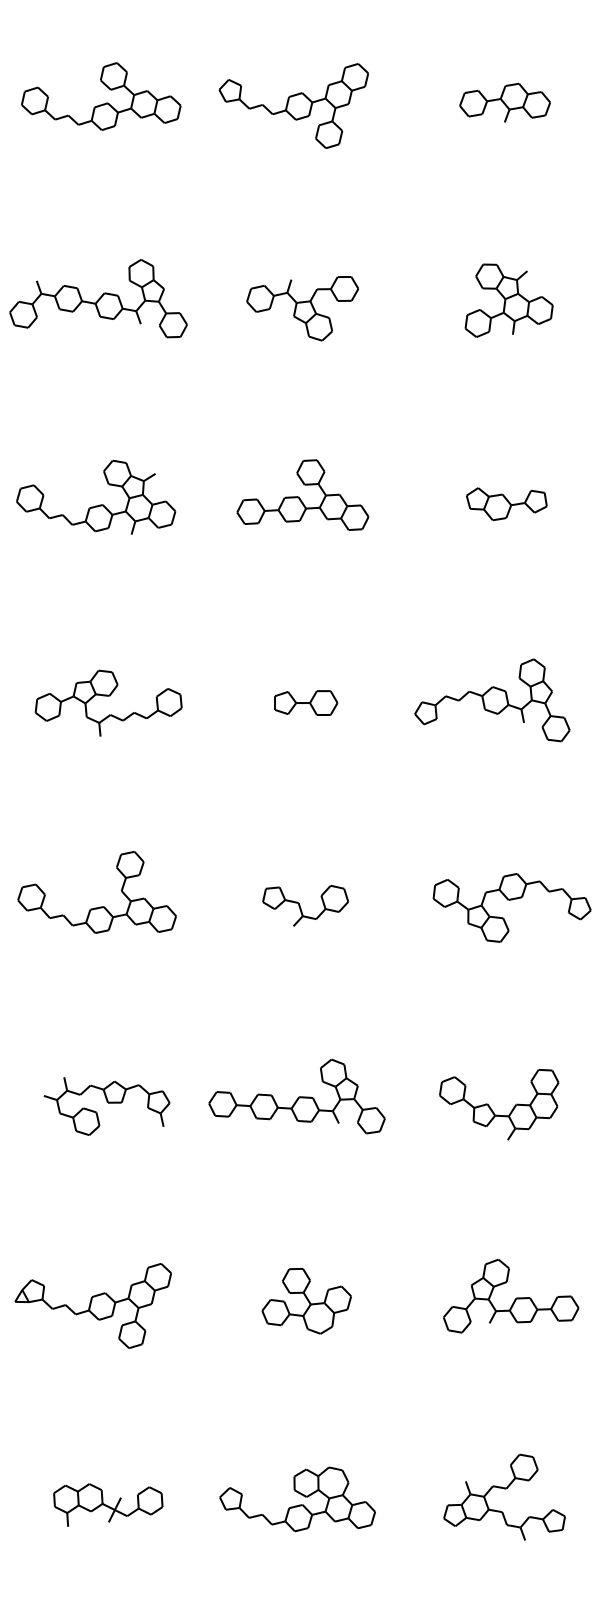

In [24]:
Chem.Draw.MolsToGridImage(list(mols))

## Scaffold clustering

In [25]:
df_molecules_std.scaffold_smiles.fillna('', inplace=True)

In [26]:
df_scaffolds = df_molecules_std.reset_index()[['scaffold_inchi_key', 'scaffold_smiles', 'scaffold_morgan_fp']].drop_duplicates().copy()

In [27]:
df_scaffolds['mol'] = list(map(MolFromSmiles, df_scaffolds.scaffold_smiles))

In [28]:
scaffold_fps = np.asarray([np.frombuffer(fp.encode('ASCII'), np.byte) - ord('0') for fp in df_scaffolds.scaffold_morgan_fp])

In [29]:
from sklearn.manifold import MDS, TSNE

In [30]:
scaffolds_tsne = TSNE().fit_transform(scaffold_fps)

In [31]:
scaffold_mds = MDS(eps=1e-1, max_iter=50).fit_transform(scaffold_fps)

In [32]:
scaffolds_pca = PCA(2).fit_transform(scaffold_fps)

In [33]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [34]:
z = linkage(scaffold_fps, method='ward', metric='euclidean')

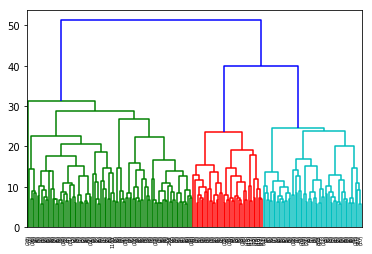

In [35]:
dendrogram(z, truncate_mode='lastp', p=200);

In [36]:
len(df_scaffolds)

1165

In [37]:
labels = fcluster(z, criterion='maxclust', t='100')
display(np.max(labels))
label_names = np.asarray(['label_'+str(x) for x in labels])

100

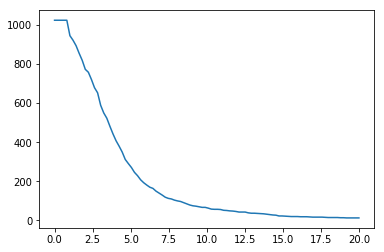

In [38]:
x = np.linspace(0,20,100)
plt.plot(x, [np.max(fcluster(z,criterion='distance',t=t)) for t in x])

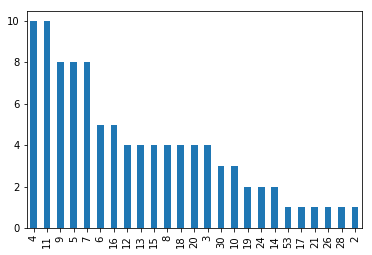

In [39]:
pd.Series(labels).value_counts().value_counts().plot(kind='bar')

In [40]:
pd.Series(labels).value_counts()[pd.Series(labels).value_counts() > 400]

Series([], dtype: int64)

In [41]:
mask = labels != 142

In [42]:
def make_colormap_cycle(x):
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    return [colors[a%len(colors)] for a in x]

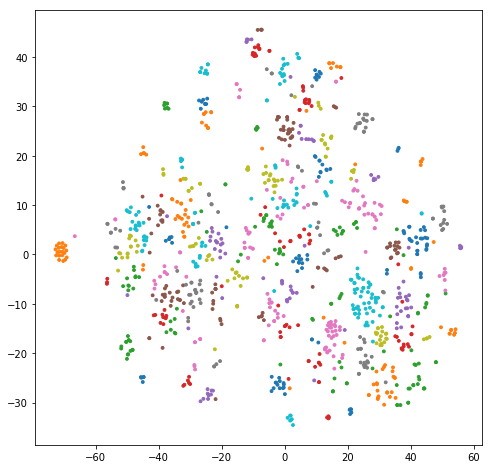

In [43]:
plt.figure(figsize=(8,8))
plt.scatter(scaffolds_tsne[mask,0], scaffolds_tsne[mask,1], alpha=1.0, s=8, c=make_colormap_cycle(labels[mask]))

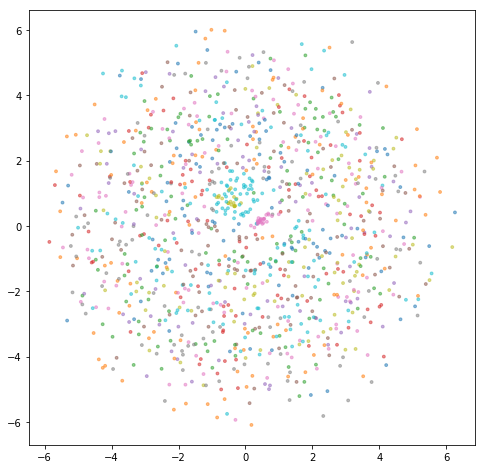

In [46]:
plt.figure(figsize=(8,8))
plt.scatter(scaffold_mds[mask,0], scaffold_mds[mask,1], alpha=0.5, s=8, c=make_colormap_cycle(labels[mask]))

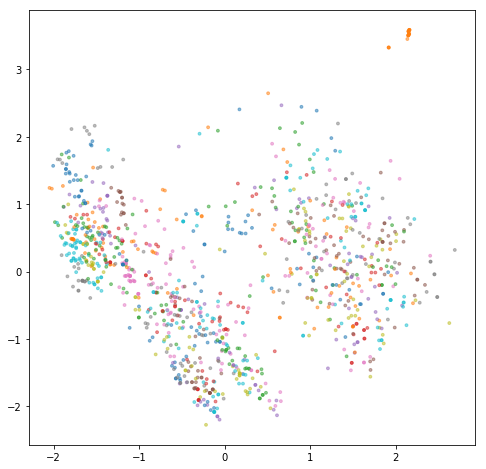

In [47]:
plt.figure(figsize=(8,8))
plt.scatter(scaffolds_pca[mask,0], scaffolds_pca[mask,1], alpha=0.5, s=8, c=make_colormap_cycle(labels[mask]))

In [48]:
df_scaffolds['cluster_label'] = label_names

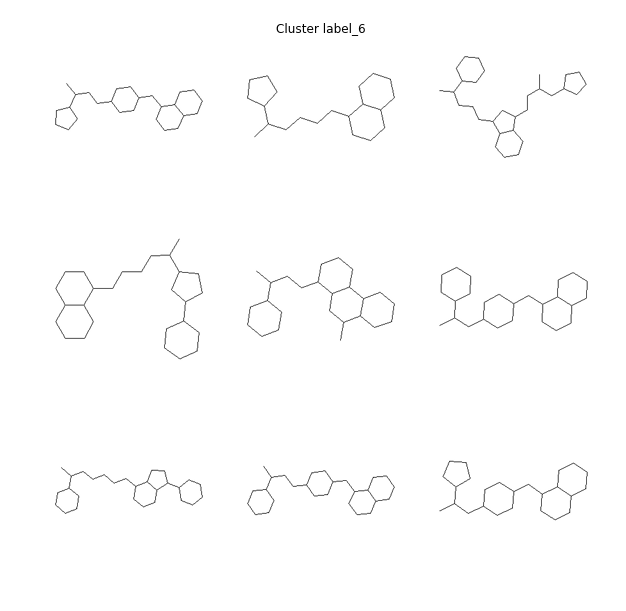

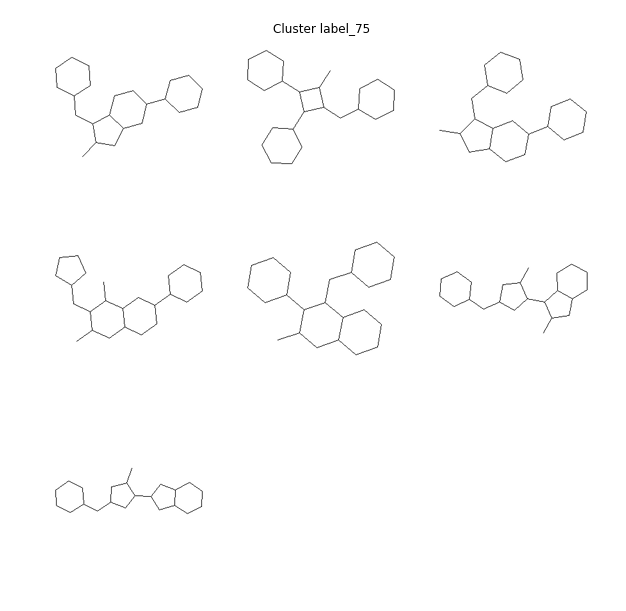

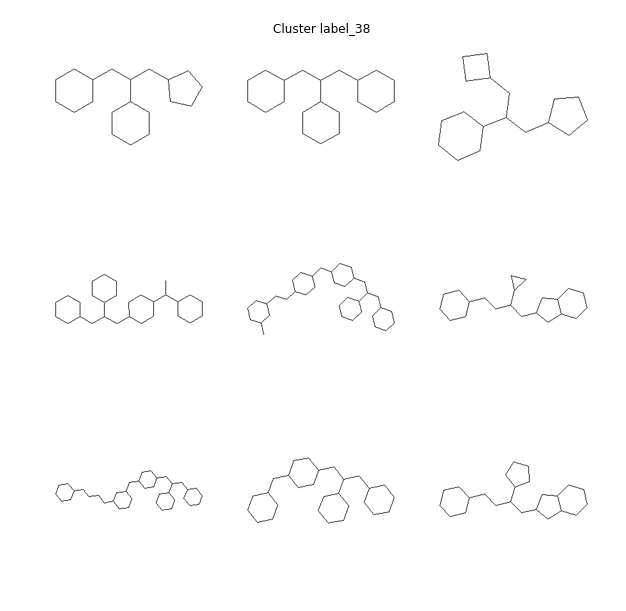

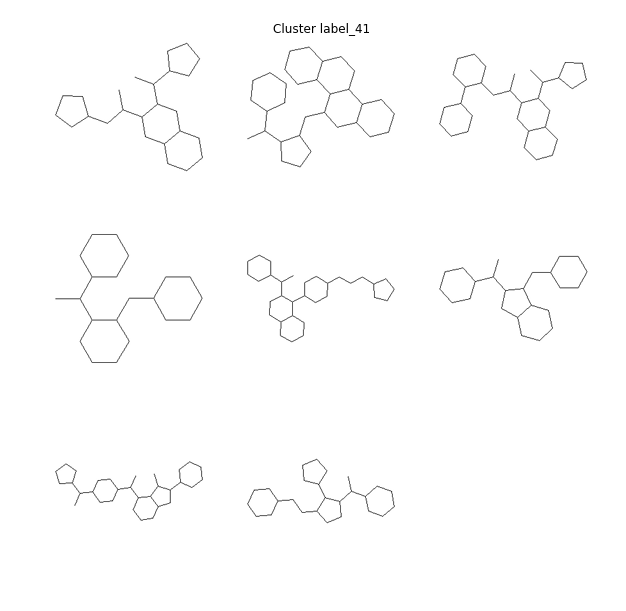

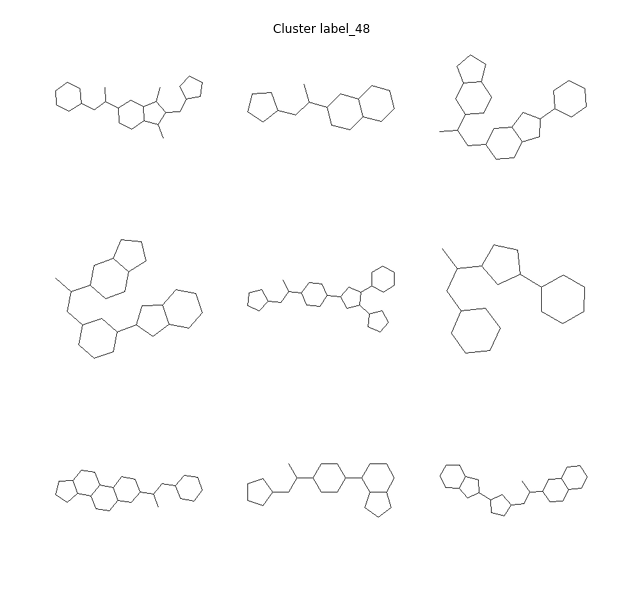

In [64]:
for c in np.random.choice(label_names,size=5,replace=False):
    mols = df_scaffolds.query('cluster_label == "%s"' % c)['mol']
    picked_scaffolds = np.random.choice(mols, size=min(9,len(mols)), replace=False)
#     img = Chem.Draw.MolsToGridImage(picked_scaffolds, subImgSize=(250,250))
    fig = plt.figure(figsize=(8,8))
    fig.suptitle('Cluster %s' % c)
    for i in range(len(picked_scaffolds)):
        plt.subplot(3,3,i+1)
        img = Chem.Draw.MolToImage(picked_scaffolds[i], fitImage=True)
        plt.axis('off')
        plt.imshow(img, aspect='equal', interpolation='spline16')
    fig.tight_layout()
    fig.subplots_adjust(left=0,right=1,bottom=0,top=1,wspace=0,hspace=0)

## ANOVA on clusters

In [404]:
df_era_scaffolds = df_era.join(df_scaffolds.set_index('scaffold_smiles'), on='scaffold_smiles', lsuffix='_l')

In [405]:
mod = ols('logIC50 ~ cluster_label', data=df_era_scaffolds).fit()

In [406]:
sm.stats.anova_lm(mod, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
cluster_label,77.0,1809.095192,23.494743,27.014781,3.795719e-236
Residual,1640.0,1426.307247,0.869700,NaN,NaN
